## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration 

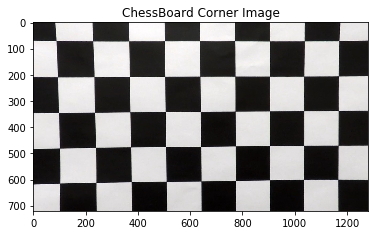

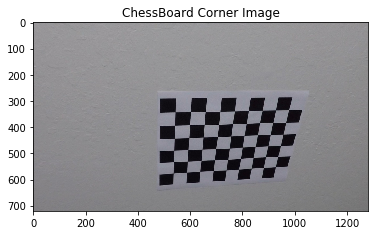

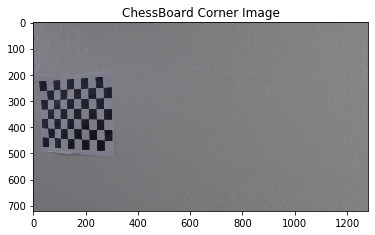

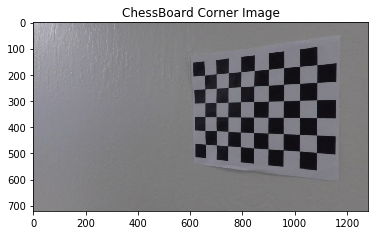

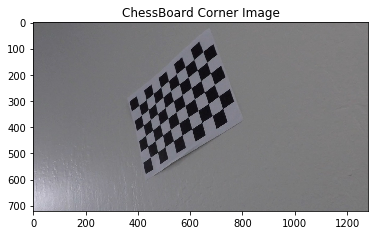

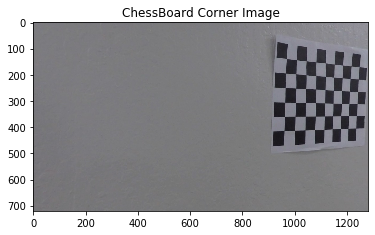

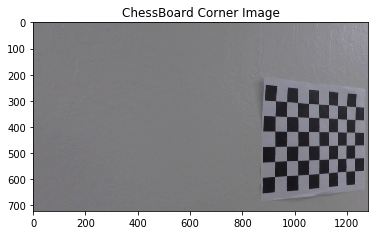

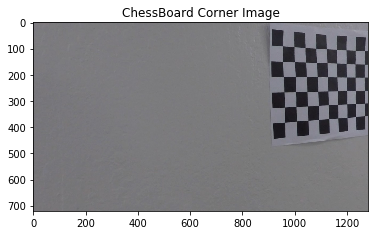

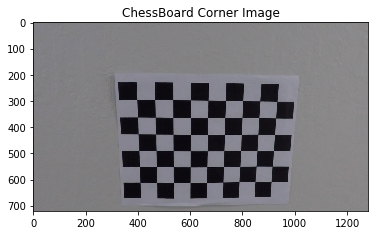

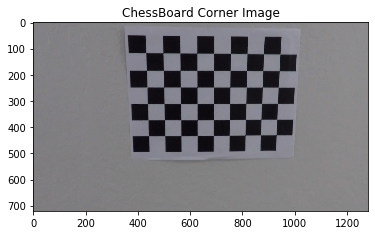

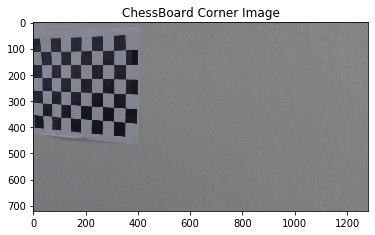

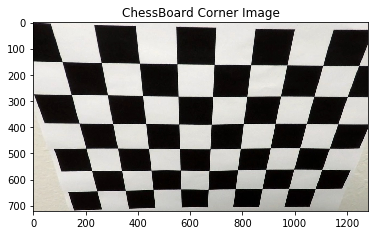

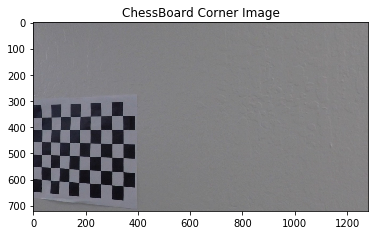

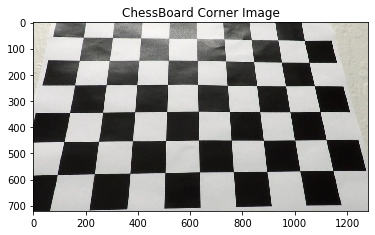

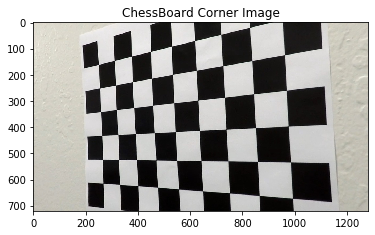

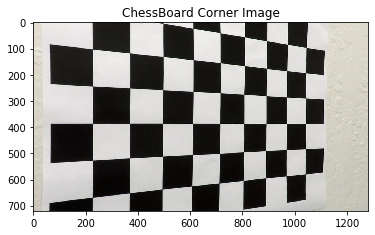

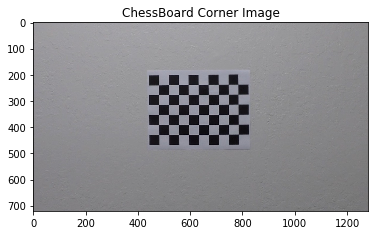

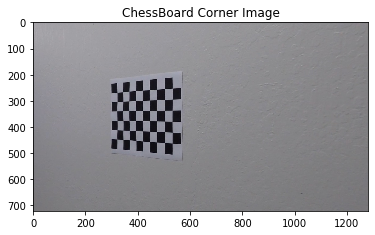

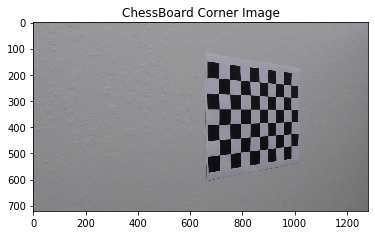

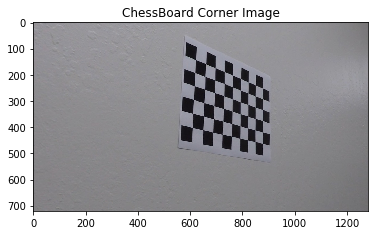

In [49]:
#Adding required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plt_img
import cv2
import glob # To read all images inside a folder

# Flag for debugging the output
DEFINE_DEBUG = 1    
 
# Write real world co-ordinates of the corners of the chess board.    
objp = np.zeros(((9*6),3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Lists for holding objects points and their image coordinates
imgpoints = []
objpoints = []

# This function return Grayscale image
def grayscale(img):    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# This function draws corners of the chess board on the color input image
def draw_chess_board_corners(ret, corners, img, objpoints, imgpoints):
    if (ret == True):
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        objpoints.append(objp)
        imgpoints.append(corners)
        if(0):
            plt.imshow(img, cmap ='gray')
            plt.title("ChessBoard Corner Image")
            plt.show()
        return objpoints, imgpoints

# This function calculates Camera matrix and Distortion coeffients 
def calibrate_camera(images):
    for image in images:
        img = plt_img.imread(image)
        gray = grayscale(img)
        if(0):
            plt.imshow(gray, cmap ='gray')
            plt.title("Grayscale image")
            plt.show()
    
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)    
        draw_chess_board_corners(ret, corners, img, objpoints, imgpoints)            
    #Calibrate camera     
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Returns Camera matrix (mtx) and Distortion coeffients (dist)
    return mtx, dist

def undistort_images(images, mtx, dist):
    for image in images:
        img = plt_img.imread(image)
        # Un-distort images
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        if(1):
            plt.imshow(dst)
            plt.title("ChessBoard Corner Image")
            plt.show()
        
if (__name__== '__main__' ):
    # Read all images from a folder
    images = glob.glob("camera_cal/*.jpg")
    
    # Calibrate Camera
    mtx, dist = calibrate_camera(images)
    
    # Undistort Images
    undistort_images(images, mtx, dist)

